## Anton Anisimov Part2-Model traning and validation

Quick plan:<br>
    <p>1)load the data </p> <br>
    2)reconstract resnet<br>
    3)train the model on my own dataset<br><br>
    4)test on Alex's data set(cleaned by me)<br>
    5)if final res is good:<br>
           finish<br>
       else:<br>
           train combine data sets<br>
           hold part to valid<br>
           back to step tain and validate<br>
     6)if final res is good:<br>
           finish<br>
       else:<br>
         crying<br>
         give up<br>
           
     

In [4]:
import torch
import glob
import time
import os
import copy
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

## DATA LOADING

In [15]:
path='data\\'

In [11]:
# get images links
APhones=glob.glob(os.path.join(path,'APhones/','*.jpg'))
Iphone=glob.glob(os.path.join(path,'Iphones/','*.jpg'))

In [12]:
print ('APhones:',len(APhones),'Iphone:',len(Iphone))

APhones: 28156 Iphone: 33791


In [102]:
#balance classes
shuffle_ap=np.random.permutation(len(APhones))
shuffle_ap=shuffle_ap[0:len(Iphone)]
f=np.array(APhones)[shuffle_ap]
files=np.append(f,Iphone)
shuffle=np.random.permutation(len(files))
print ('APhones:',len(f),'Iphone:',len(Iphone))

APhones: 8960 Iphone: 8960


In [22]:
# Prepocessing folders
os.mkdir(os.path.join(path,'val'))
os.mkdir(os.path.join(path,'train'))
os.mkdir(os.path.join(path,'test'))
for t in ['train/','val/']:
    for folder in ['APhones','Iphones']:
        os.mkdir(os.path.join(path,t,folder))

In [24]:
# Split1-Move from main to valid
for i in shuffle[:2000]:
    folder=files[i].split('\\')[1]
    image=files[i].split('\\')[-1]
    os.rename(files[i],os.path.join(path,'val',folder,image))

In [107]:
# Split2-Move from main to train
for i in shuffle[2000:]:
    folder=files[i].split('\\')[1]
    image=files[i].split('\\')[-1]
    os.rename(files[i],os.path.join(path,'train',folder,image))

In [6]:
# making image folders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.RandomRotation(15),
        transforms.Pad(1),
        transforms.CenterCrop(430),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.RandomRotation(15),
        transforms.Pad(1),
        transforms.CenterCrop(430),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    }

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=6)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

NameError: name 'data_transforms' is not defined

In [6]:
class_names

['APhones', 'Iphone']

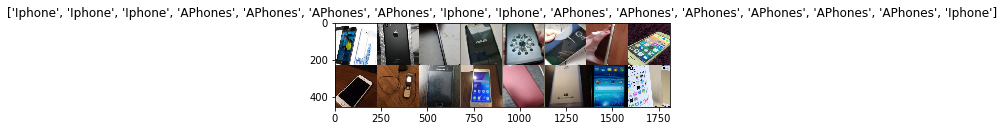

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## THE MODEL TRANING

To train model I decided to get pre-trained model ResNet18 and use it for transfer learning. I used Anton's(my) data set As traning data set,which was downloaded in part one(Data_collection.ipynb). I choosed Pytorch as main net framework and used cuda archecture(I tried do code flexible for both GPU and CPU,but I used GPU, some parts of code may not work on CPU ).

In [61]:
# get_model
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():param.requires_grad = False

In [47]:
# set tranig parametrs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [2]:
# train function witch return best models 3 metrics acc,auc,f1
def train_model(model,criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_f1 = copy.deepcopy(model.state_dict())
    best_acc,best_f1 = 0.0,0.0
    for epoch in range(num_epochs):
        epoch_f1_collection=[]
        epoch_acc_collection=[]
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    y_true=labels.cpu().data.numpy()
                    y_pred=preds.cpu().data.numpy()
                    epoch_f1=metrics.f1_score(y_true, y_pred , average='binary')
                    epoch_f1_collection.append(epoch_f1)
                    epoch_acc=metrics.accuracy_score(y_true, y_pred)
                    epoch_acc_collection.append(epoch_acc)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #             Statistic metrics
            epoch_loss = running_loss / dataset_sizes[phase]             
            print('{} Loss: {:.4f} Acc: {:.4f}  F1: {:.4f}'.format(
                phase, epoch_loss, np.mean(epoch_acc_collection),np.mean(epoch_f1_collection)))
            # deep copy the model
            if phase == 'val' and np.mean(epoch_acc_collection) > best_acc:
                best_acc = np.mean(epoch_acc_collection)
            if phase == 'val' and np.mean(epoch_f1_collection) > best_f1:
                best_f1 = np.mean(epoch_f1_collection)
                best_model_f1 = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} F1: {:.4f}'.format(best_acc,best_f1))
    model.load_state_dict(best_model_f1)
    return model

In [74]:
# model1,model2,model3=train_model(model_conv,criterion, optimizer_conv, exp_lr_scheduler, num_epochs=1)
model1=train_model(model_conv,criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2671 Acc: 0.9015  F1: 0.8999
val Loss: 0.1508 Acc: 0.9075  F1: 0.9061

Epoch 1/24
----------
train Loss: 0.1413 Acc: 0.9571  F1: 0.9564
val Loss: 0.1225 Acc: 0.9577  F1: 0.9570

Epoch 2/24
----------
train Loss: 0.1211 Acc: 0.9633  F1: 0.9628
val Loss: 0.1254 Acc: 0.9622  F1: 0.9618

Epoch 3/24
----------
train Loss: 0.1110 Acc: 0.9648  F1: 0.9645
val Loss: 0.1030 Acc: 0.9649  F1: 0.9645

Epoch 4/24
----------
train Loss: 0.1018 Acc: 0.9673  F1: 0.9670
val Loss: 0.0971 Acc: 0.9679  F1: 0.9675

Epoch 5/24
----------
train Loss: 0.0981 Acc: 0.9689  F1: 0.9683
val Loss: 0.0934 Acc: 0.9691  F1: 0.9686

Epoch 6/24
----------
train Loss: 0.0951 Acc: 0.9706  F1: 0.9701
val Loss: 0.0886 Acc: 0.9707  F1: 0.9702

Epoch 7/24
----------
train Loss: 0.0970 Acc: 0.9668  F1: 0.9657
val Loss: 0.0878 Acc: 0.9678  F1: 0.9669

Epoch 8/24
----------
train Loss: 0.0932 Acc: 0.9711  F1: 0.9704
val Loss: 0.0889 Acc: 0.9714  F1: 0.9707

Epoch 9/24
----------
train Loss: 0.0

In [3]:
checkpoint = {'model': model1,
          'state_dict': model1.state_dict(),
          'optimizer' : optimizer_conv.state_dict()}

torch.save(checkpoint, 'model4.pth')

NameError: name 'model1' is not defined

## Test the Model on Alexandr's data set 


In [1]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model


In [ ]:
model = load_checkpoint('model4.pth')

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
# import test data
simple_transform=transforms.Compose([transforms.Resize((512,512)),
                                     transforms.Pad(1),
                                     transforms.CenterCrop(430),
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test = datasets.ImageFolder('Alex_pre_clean/',simple_transform)

FileNotFoundError: [Errno 2] No such file or directory: 'Alex_pre_clean/'

In [6]:
test_data_gen=torch.utils.data.DataLoader(test, batch_size=256,shuffle=True, num_workers=6)

NameError: name 'test' is not defined

In [16]:
# boostrap_test
def boostrap_test(model,loader):
    y_true=[]
    y_pred=[]
    X=[]
    f1_test_distribe=[]
    for inputs,labels in loader:
        x=inputs.to('cuda')
        outputs=model(x)
        _, preds = torch.max(outputs, 1)
        y_true.append(labels.cpu().data.numpy())
        y_pred.append(preds.cpu().data.numpy())
        X.append(inputs.cpu().data.numpy())
        f1_test_distribe.append(metrics.f1_score(
            labels.cpu().data.numpy(),
            preds.cpu().data.numpy(),average='binary'))
    return X,y_true,y_pred,np.array(f1_test_distribe)
    

In [ ]:
inputs,y_true,y_pred,f1_test_distribe=boostrap_test(model,test_data_gen)

In [64]:
print (y_true[10])
print (y_pred[10])


[1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0
 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0
 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0
 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1
 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1
 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1
 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [72]:
print (y_true[10].shape)
print (inputs.shape)

(256,)

In [71]:
inputs[y_pred[10]!=y_true[10]]

(253, 3, 224, 224)

(array([ 4., 13., 29., 34., 39., 41., 24., 13.,  6.,  4.]),
 array([0.        , 0.01441441, 0.02882883, 0.04324324, 0.05765766,
        0.07207207, 0.08648649, 0.1009009 , 0.11531532, 0.12972973,
        0.14414414]),
 <a list of 10 Patch objects>)

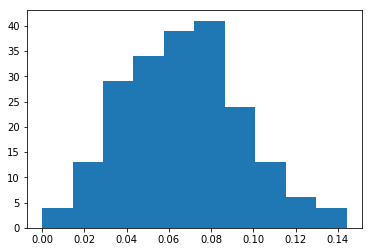

In [65]:
from matplotlib.pyplot import hist
hist(f1_test_distribe)

In [18]:
print ('real_mean:',np.mean(f1_test_distribe))


real_mean: 0.06536765463236797


So,the model has low f1 score on Alex's set ,but it is not time to cry. Now first model woks bad on several models of iphones,so lets make final merge data set, shuffle it and hold train,valid,and final test folders  

## Merge and Train

In [19]:
path='Final_set\\'

In [20]:
path='Final_set\\'
files=glob.glob(os.path.join(path,'*/*.jpg'))
shuffle=np.random.permutation(len(files))
len(files)

0

In [50]:
# Prepocessing folders
os.mkdir(os.path.join(path,'val'))
os.mkdir(os.path.join(path,'train'))
os.mkdir(os.path.join(path,'test'))
for t in ['train/','val/']:
    for folder in ['APhones','Iphones']:
        os.mkdir(os.path.join(path,t,folder))

In [35]:
# Split2-Move from main to train
for i in shuffle[:2000]:
    folder=files[i].split('\\')[1]
    image=files[i].split('\\')[-1]
    os.rename(files[i],os.path.join(path,'val',folder,image))

In [37]:
for i in shuffle[-2000:]:
    folder=files[i].split('\\')[1]
    image=files[i].split('\\')[-1]
    os.rename(files[i],os.path.join(path,'test',folder,image))

In [38]:
for i in shuffle[2000:-2000]:
    folder=files[i].split('\\')[1]
    image=files[i].split('\\')[-1]
    os.rename(files[i],os.path.join(path,'train',folder,image))

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.RandomRotation(15),
        transforms.Pad(1),
        transforms.CenterCrop(430),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.RandomRotation(15),
        transforms.Pad(1),
        transforms.CenterCrop(430),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.RandomRotation(15),
        transforms.Pad(1),
        transforms.CenterCrop(430),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    }

In [59]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=6)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

In [24]:
class_names

['APhones', 'Iphones']

In [50]:
# get_model
model_conv_1 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_1.parameters():param.requires_grad = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_ftrs = model_conv_1.fc.in_features
model_conv_1.fc = nn.Linear(num_ftrs, 2)
model_conv_1 = model_conv_1.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv_1.fc.parameters(), lr=0.0016)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [51]:
model2=train_model(model_conv_1,criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5310 Acc: 0.7341  F1: 0.7503
val Loss: 0.4604 Acc: 0.7357  F1: 0.7511

Epoch 1/24
----------
train Loss: 0.5164 Acc: 0.7484  F1: 0.7622
val Loss: 0.4517 Acc: 0.7498  F1: 0.7632

Epoch 2/24
----------
train Loss: 0.5135 Acc: 0.7515  F1: 0.7652
val Loss: 0.5616 Acc: 0.7503  F1: 0.7652

Epoch 3/24
----------
train Loss: 0.5162 Acc: 0.7493  F1: 0.7639
val Loss: 0.4622 Acc: 0.7505  F1: 0.7644

Epoch 4/24
----------
train Loss: 0.5129 Acc: 0.7507  F1: 0.7648
val Loss: 0.4632 Acc: 0.7511  F1: 0.7650

Epoch 5/24
----------
train Loss: 0.5147 Acc: 0.7523  F1: 0.7674
val Loss: 0.4696 Acc: 0.7533  F1: 0.7672

Epoch 6/24
----------
train Loss: 0.4754 Acc: 0.7672  F1: 0.7825
val Loss: 0.4458 Acc: 0.7679  F1: 0.7827

Epoch 7/24
----------
train Loss: 0.4732 Acc: 0.7695  F1: 0.7845
val Loss: 0.4472 Acc: 0.7701  F1: 0.7845

Epoch 8/24
----------
train Loss: 0.4727 Acc: 0.7694  F1: 0.7851
val Loss: 0.4522 Acc: 0.7699  F1: 0.7854

Epoch 9/24
----------
train Loss: 0.4

In [52]:
checkpoint = {'model': model2,
          'state_dict': model2.state_dict(),
          'optimizer' : optimizer_conv.state_dict()}

torch.save(checkpoint, 'mearge2_batch16.pth')

In [53]:
inputs,y_true,y_pred,f1_test_distribe=boostrap_test(model2,dataloaders['test'])

In [57]:
print ('real_mean:',np.mean(f1_test_distribe))

real_mean: 0.7848157005143195


(array([ 4.,  4.,  7., 13., 18., 19., 17., 20., 16.,  7.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 10 Patch objects>)

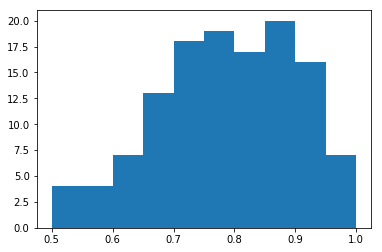

In [58]:
hist(f1_test_distribe)

Good news, now the model is stable and lies in the interval 70%-90%. So,lets try to use more deep net

## ResNet50

In [32]:
# get_model
model_conv_2 = torchvision.models.resnet50(pretrained=True)
for param in model_conv_2.parameters():param.requires_grad = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_ftrs = model_conv_2.fc.in_features
model_conv_2.fc = nn.Linear(num_ftrs, 2)
model_conv_2 = model_conv_2.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv_2.fc.parameters(), lr=0.00016)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Антон/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:15<00:00, 6777781.98it/s]


In [56]:
model3=train_model(model3,criterion, optimizer_conv, exp_lr_scheduler, num_epochs=24)

Epoch 0/23
----------


KeyboardInterrupt: 

In [ ]:
checkpoint = {'model': model3,
          'state_dict': model3.state_dict(),
          'optimizer' : optimizer_conv.state_dict()}

torch.save(checkpoint, 'resnet50_batch15.pth')

In [ ]:
dataloaders = torch.utils.data.DataLoader(image_datasets['test'], batch_size=16,
                                             shuffle=True, num_workers=6)

In [ ]:
y_true,y_pred,f1_test_distribe=boostrap_test(model3,dataloaders)
print ('real_mean:',np.mean(f1_test_distribe))

(array([ 2.,  4.,  3.,  8., 10., 23., 27., 25., 12., 11.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 10 Patch objects>)

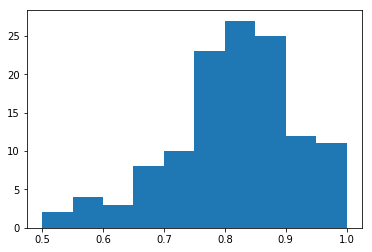

In [48]:
hist(f1_test_distribe)

## Full learning Resnet18

In [4]:
path='Final_set'

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.RandomRotation(15),
        transforms.Pad(1),
        transforms.CenterCrop(430),
        transforms.Resize((224,224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    }

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=6)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

In [17]:
class_names

['APhones', 'Iphones']

In [12]:
# get_model
model_conv_1 = torchvision.models.resnet18(pretrained=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_ftrs = model_conv_1.fc.in_features
model_conv_1.fc = nn.Linear(num_ftrs, 2)
model_conv_1 = model_conv_1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv_1.parameters(), lr=0.0019, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
def save_model1(model_conv_1):
    checkpoint = {'model': model_conv_1,
              'state_dict': model_conv_1.state_dict(),
              'optimizer' : optimizer_conv.state_dict()}

    torch.save(checkpoint, 'new_test.pth')

In [24]:
# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = checkpoint['model']
#     model.load_state_dict(checkpoint['state_dict'])
#     model.eval()
#     return model
# model_conv_1 = load_checkpoint('mearge2_batch16.pth')

In [26]:
optimizer_conv = optim.Adam(model_conv_1.parameters(), lr=0.0019)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
def train_model1(model,criterion, optimizer, scheduler, num_epochs=25):
    model1=model
    since = time.time()
    best_model_f1 = copy.deepcopy(model.state_dict())
    best_acc,best_f1 = 0.0,0.0
    for epoch in range(num_epochs):
        since1 = time.time()
        epoch_f1_collection=[]
        epoch_acc_collection=[]
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    y_true=labels.cpu().data.numpy()
                    y_pred=preds.cpu().data.numpy()
                    epoch_f1=metrics.f1_score(y_true, y_pred , average='binary')
                    epoch_f1_collection.append(epoch_f1)
                    epoch_acc=metrics.accuracy_score(y_true, y_pred)
                    epoch_acc_collection.append(epoch_acc)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #             Statistic metrics
            epoch_loss = running_loss / dataset_sizes[phase]             
            print('{} Loss: {:.4f} Acc: {:.4f}  F1: {:.4f}'.format(
                phase, epoch_loss, np.mean(epoch_acc_collection),np.mean(epoch_f1_collection)))
            time_elapsed1 = time.time() - since1
            print('Epoch complete in {:.0f}m {:.0f}s'.format(
            time_elapsed1 // 60, time_elapsed1 % 60))
            # deep copy the model
            if phase == 'val' and np.mean(epoch_acc_collection) > best_acc:
                best_acc = np.mean(epoch_acc_collection)
            if phase == 'val' and np.mean(epoch_f1_collection) > best_f1:
                best_f1 = np.mean(epoch_f1_collection)
                best_model_f1 = copy.deepcopy(model.state_dict())
                model1.load_state_dict(best_model_f1)
                save_model1(model1)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} F1: {:.4f}'.format(best_acc,best_f1))
    model.load_state_dict(best_model_f1)
    
    return model

In [26]:
optimizer_conv = optim.Adam(model_conv_1.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=11, gamma=0.1)

In [2]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

In [10]:
model_conv_1=load_checkpoint('good.pth')


In [12]:
# model=model_conv_1.to('cpu')

In [ ]:
checkpoint = {'model': model_conv_1,
          'state_dict': model_conv_1.state_dict(),
          'optimizer' : optimizer_conv.state_dict()}

torch.save(checkpoint, 'lada_1.pth')

In [27]:
model_conv_1=train_model1(model_conv_1,criterion, optimizer_conv, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.1779 Acc: 0.9222  F1: 0.9233
Epoch complete in 6m 8s
val Loss: 0.5192 Acc: 0.9190  F1: 0.9209
Epoch complete in 6m 13s

Epoch 1/1
----------


KeyboardInterrupt: 

In [25]:
checkpoint = {'model': model_conv_1,
          'state_dict': model_conv_1.state_dict(),
          'optimizer' : optimizer_conv.state_dict()}

torch.save(checkpoint, 'model_ip.pth')

## Final test Area under precision and recall

In [5]:
model=load_checkpoint('model_ip.pth')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
#Image convert
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#Define images loader
image_datasets = ImageFolder('Final_set\\test',data_transforms)
test_data_gen=torch.utils.data.DataLoader(image_datasets, batch_size=256,shuffle=False, num_workers=6)

In [7]:
from sklearn.metrics import average_precision_score
preds=np.array([])
true=np.array([])
for inputs, labels in test_data_gen:
    preds=np.append(preds,model(inputs).data.numpy()[:,1])
    true=np.append(true,labels)
print (average_precision_score(true, preds)) 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9741226669568382
